Optimizing Clinic Scheduling for Endocrinology and Diabetes: Minimizing Patient Demand Shortfalls Through Resource Allocation

Author: Youssef Elsakkary

This project focuses on optimizing the scheduling of clinic rooms and staff to better meet patient demand for endocrinology and diabetes clinics. By utilizing linear programming, the goal is to minimize gaps between patient needs and available resources, addressing shortfalls in service delivery. The solution includes balancing room usage, managing provider and nurse work hours, and ensuring effective allocation of resources to reduce unmet demand across various time slots and days of the week. The results are visualized through heatmaps that highlight areas of demand shortfall, providing insights for improved scheduling and resource management.

Importing Necessary Libraries

In [4]:
import pandas as pd
from pulp import LpProblem, LpVariable, lpSum, LpMinimize
import matplotlib.pyplot as plt
import seaborn as sns

Define Problem & Parameters

In [6]:
# Define the problem
prob = LpProblem("Demand_Optimization", LpMinimize)

# Define parameters
number_days = 7
number_rooms = 12
number_slots_per_day = 16  # 30-minute slots from 8 AM to 4 PM
number_providers = 6
number_nurses = 8
max_hours_per_week = 40


Define Decision Variables For Each Time Slot & Day

In [8]:
assign_endocrinology = [
    [
        [LpVariable(f'assign_endocrinology_{i+1}_{j+1}_{k+1}', cat='Binary')
         for i in range(number_rooms)]
        for j in range(number_days)]
    for k in range(number_slots_per_day)
]

assign_diabetes = [
    [
        [LpVariable(f'assign_diabetes_{i+1}_{j+1}_{k+1}', cat='Binary')
         for i in range(number_rooms)]
        for j in range(number_days)]
    for k in range(number_slots_per_day)
]

Define Decision Variables for Provider & Nurse Assignments

In [10]:
assign_providers_endocrinology = [
    [
        [LpVariable(f'assign_providers_endocrinology_{i+1}_{j+1}_{k+1}', cat='Binary')
         for i in range(number_providers)]
        for j in range(number_days)]
    for k in range(number_slots_per_day)
]

assign_providers_diabetes = [
    [
        [LpVariable(f'assign_providers_diabetes_{i+1}_{j+1}_{k+1}', cat='Binary')
         for i in range(number_providers)]
        for j in range(number_days)]
    for k in range(number_slots_per_day)
]

assign_nurses_endocrinology = [
    [
        [LpVariable(f'assign_nurses_endocrinology_{i+1}_{j+1}_{k+1}', cat='Binary')
         for i in range(number_nurses)]
        for j in range(number_days)]
    for k in range(number_slots_per_day)
]

assign_nurses_diabetes = [
    [
        [LpVariable(f'assign_nurses_diabetes_{i+1}_{j+1}_{k+1}', cat='Binary')
         for i in range(number_nurses)]
        for j in range(number_days)]
    for k in range(number_slots_per_day)
]


Define Fixed Demand Values

In [12]:
demand_endocrinology = [
    [4, 5, 6, 5, 4, 4, 3, 3, 3, 4, 5, 6, 4, 4, 3, 3],  # Monday
    [3, 4, 5, 5, 4, 4, 3, 3, 3, 4, 5, 6, 4, 4, 3, 3],  # Tuesday
    [4, 5, 6, 6, 4, 4, 3, 3, 4, 5, 6, 6, 5, 4, 3, 3],  # Wednesday
    [5, 6, 6, 5, 5, 5, 4, 4, 4, 5, 6, 6, 5, 5, 4, 4],  # Thursday
    [6, 6, 6, 5, 5, 5, 4, 4, 5, 6, 6, 6, 5, 5, 5, 4],  # Friday
    [5, 5, 5, 4, 4, 4, 4, 3, 4, 5, 5, 5, 4, 4, 3, 3],  # Saturday
    [4, 4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 5, 4, 4, 3, 3]   # Sunday
]

demand_diabetes = [
    [8, 7, 6, 7, 8, 8, 9, 9, 9, 8, 7, 6, 8, 8, 9, 9],  # Monday
    [9, 8, 7, 7, 8, 8, 9, 9, 9, 8, 7, 6, 8, 8, 9, 9],  # Tuesday
    [8, 7, 6, 6, 8, 8, 9, 9, 8, 7, 6, 6, 7, 8, 9, 9],  # Wednesday
    [7, 6, 6, 7, 7, 7, 8, 8, 8, 7, 6, 6, 7, 7, 8, 8],  # Thursday
    [6, 6, 6, 7, 7, 7, 8, 8, 7, 6, 6, 6, 7, 7, 7, 8],  # Friday
    [7, 7, 7, 8, 8, 8, 8, 9, 7, 6, 6, 6, 7, 7, 8, 8],  # Saturday
    [8, 8, 8, 8, 9, 9, 9, 9, 8, 8, 8, 7, 8, 8, 8, 9]   # Sunday
]

Define Auxiliary Variables for Shortfall

In [14]:
shortfall_endocrinology = [
    [LpVariable(f'shortfall_endocrinology_{j+1}_{k+1}', lowBound=0) 
     for k in range(number_slots_per_day)]
    for j in range(number_days)
]

shortfall_diabetes = [
    [LpVariable(f'shortfall_diabetes_{j+1}_{k+1}', lowBound=0) 
     for k in range(number_slots_per_day)]
    for j in range(number_days)
]

Constraints For Shortfalls For Each Time Slot of Each Day

In [16]:
for j in range(number_days):
    for k in range(number_slots_per_day):
        prob += shortfall_endocrinology[j][k] >= demand_endocrinology[j][k] - lpSum(assign_endocrinology[k][j])
        prob += shortfall_diabetes[j][k] >= demand_diabetes[j][k] - lpSum(assign_diabetes[k][j])


Constraints to Ensure No Room Is Used For Both Purposes Simultaneously

In [18]:
for j in range(number_days):
    for k in range(number_slots_per_day):
        for i in range(number_rooms):
            prob += assign_endocrinology[k][j][i] + assign_diabetes[k][j][i] <= 1, f"Room_Usage_Constraint_{i+1}_{j+1}_{k+1}"


Constraints to Ensure Total Number of Rooms Assigned to Each Service Does Not Exceed Available Rooms

In [20]:
for j in range(number_days):
    for k in range(number_slots_per_day):
        prob += lpSum(assign_endocrinology[k][j]) <= number_rooms, f"Total_Rooms_Endocrinology_{j+1}_{k+1}"
        prob += lpSum(assign_diabetes[k][j]) <= number_rooms, f"Total_Rooms_Diabetes_{j+1}_{k+1}"


Constraints for Weekly Working Hours for Providers & Nurses

In [22]:
for p in range(number_providers):
    prob += lpSum(assign_providers_endocrinology[k][j][p] for k in range(number_slots_per_day) for j in range(number_days)) <= max_hours_per_week, \
        f"Max_Weekly_Hours_Providers_Endocrinology_{p+1}"
    prob += lpSum(assign_providers_diabetes[k][j][p] for k in range(number_slots_per_day) for j in range(number_days)) <= max_hours_per_week, \
        f"Max_Weekly_Hours_Providers_Diabetes_{p+1}"

for n in range(number_nurses):
    prob += lpSum(assign_nurses_endocrinology[k][j][n] for k in range(number_slots_per_day) for j in range(number_days)) <= max_hours_per_week, \
        f"Max_Weekly_Hours_Nurses_Endocrinology_{n+1}"
    prob += lpSum(assign_nurses_diabetes[k][j][n] for k in range(number_slots_per_day) for j in range(number_days)) <= max_hours_per_week, \
        f"Max_Weekly_Hours_Nurses_Diabetes_{n+1}"

Constraints to Ensure Number of Providers & Nurses Used Does Not Exceed Their Availability

In [24]:
for j in range(number_days):
    for k in range(number_slots_per_day):
        # Providers constraint
        prob += lpSum(assign_providers_endocrinology[k][j][i] for i in range(number_providers)) <= number_providers, f"Providers_Endocrinology_{j+1}_{k+1}"
        prob += lpSum(assign_providers_diabetes[k][j][i] for i in range(number_providers)) <= number_providers, f"Providers_Diabetes_{j+1}_{k+1}"
        
        # Nurses constraint
        prob += lpSum(assign_nurses_endocrinology[k][j][i] for i in range(number_nurses)) <= number_nurses, f"Nurses_Endocrinology_{j+1}_{k+1}"
        prob += lpSum(assign_nurses_diabetes[k][j][i] for i in range(number_nurses)) <= number_nurses, f"Nurses_Diabetes_{j+1}_{k+1}"
        
        # Constraints to ensure no room is over-utilized by providers or nurses
        for i in range(number_rooms):
            prob += lpSum(assign_providers_endocrinology[k][j][p] for p in range(number_providers)) + \
                    lpSum(assign_providers_diabetes[k][j][p] for p in range(number_providers)) <= 1, \
                f"Provider_Usage_Constraint_{i+1}_{j+1}_{k+1}"
            prob += lpSum(assign_nurses_endocrinology[k][j][n] for n in range(number_nurses)) + \
                    lpSum(assign_nurses_diabetes[k][j][n] for n in range(number_nurses)) <= 1, \
                f"Nurse_Usage_Constraint_{i+1}_{j+1}_{k+1}"


Define Objective Function to Minimize Total Shortfall

In [26]:
prob += lpSum(shortfall_endocrinology[j][k] for j in range(number_days) for k in range(number_slots_per_day)) + \
        lpSum(shortfall_diabetes[j][k] for j in range(number_days) for k in range(number_slots_per_day))


Solve & Print Results

In [28]:
prob.solve()

# Print results
total_shortfall_endocrinology = sum(s.value() for j in range(number_days) for s in shortfall_endocrinology[j])
total_shortfall_diabetes = sum(s.value() for j in range(number_days) for s in shortfall_diabetes[j])
valid_solution = True

for j in range(number_days):
    for k in range(number_slots_per_day):
        rooms_endocrinology = [i+1 for i in range(number_rooms) if assign_endocrinology[k][j][i].value() == 1]
        rooms_diabetes = [i+1 for i in range(number_rooms) if assign_diabetes[k][j][i].value() == 1]
        
        # Calculate additional rooms needed
        assigned_endocrinology = sum(assign_endocrinology[k][j][i].value() for i in range(number_rooms))
        assigned_diabetes = sum(assign_diabetes[k][j][i].value() for i in range(number_rooms))
        
        additional_endocrinology = max(demand_endocrinology[j][k] - assigned_endocrinology, 0)
        additional_diabetes = max(demand_diabetes[j][k] - assigned_diabetes, 0)

        if additional_endocrinology > 0 or additional_diabetes > 0:
            valid_solution = False
        
        print(f"Day {j+1}, Slot {k+1}:")
        print(f"  Rooms assigned to Endocrinology: {rooms_endocrinology}")
        print(f"  Rooms assigned to Diabetes: {rooms_diabetes}")
        print(f"  Additional Rooms Needed for Endocrinology: {additional_endocrinology}")
        print(f"  Additional Rooms Needed for Diabetes: {additional_diabetes}")

print(f"Total Shortfall Endocrinology = {total_shortfall_endocrinology}")
print(f"Total Shortfall Diabetes = {total_shortfall_diabetes}")

if valid_solution:
    print("Model has successfully met all constraints!")
else:
    print("Model did not meet all constraints.")


Day 1, Slot 1:
  Rooms assigned to Endocrinology: [6, 7, 8, 9]
  Rooms assigned to Diabetes: [1, 2, 3, 4, 5, 10, 11, 12]
  Additional Rooms Needed for Endocrinology: 0.0
  Additional Rooms Needed for Diabetes: 0.0
Day 1, Slot 2:
  Rooms assigned to Endocrinology: [5, 6, 7, 8, 9]
  Rooms assigned to Diabetes: [1, 2, 3, 4, 10, 11, 12]
  Additional Rooms Needed for Endocrinology: 0.0
  Additional Rooms Needed for Diabetes: 0.0
Day 1, Slot 3:
  Rooms assigned to Endocrinology: [4, 5, 6, 7, 8, 9]
  Rooms assigned to Diabetes: [1, 2, 3, 10, 11, 12]
  Additional Rooms Needed for Endocrinology: 0.0
  Additional Rooms Needed for Diabetes: 0.0
Day 1, Slot 4:
  Rooms assigned to Endocrinology: [5, 6, 7, 8, 9]
  Rooms assigned to Diabetes: [1, 2, 3, 4, 10, 11, 12]
  Additional Rooms Needed for Endocrinology: 0.0
  Additional Rooms Needed for Diabetes: 0.0
Day 1, Slot 5:
  Rooms assigned to Endocrinology: [5, 6, 8, 9]
  Rooms assigned to Diabetes: [1, 2, 3, 4, 7, 10, 11, 12]
  Additional Rooms Need

Calculate Unmet Demand

In [30]:
unmet_demand_endocrinology = [
    [shortfall_endocrinology[j][k].value() for k in range(number_slots_per_day)]
    for j in range(number_days)
]

unmet_demand_diabetes = [
    [shortfall_diabetes[j][k].value() for k in range(number_slots_per_day)]
    for j in range(number_days)
]


Create DataFrames for Unmet Demand Heatmaps

In [32]:
df_unmet_endocrinology = pd.DataFrame(
    data=unmet_demand_endocrinology,
    index=[f'Day {i+1}' for i in range(number_days)],
    columns=[f'Slot {k+1}' for k in range(number_slots_per_day)]
)

df_unmet_diabetes = pd.DataFrame(
    data=unmet_demand_diabetes,
    index=[f'Day {i+1}' for i in range(number_days)],
    columns=[f'Slot {k+1}' for k in range(number_slots_per_day)]
)

Create Heatmaps

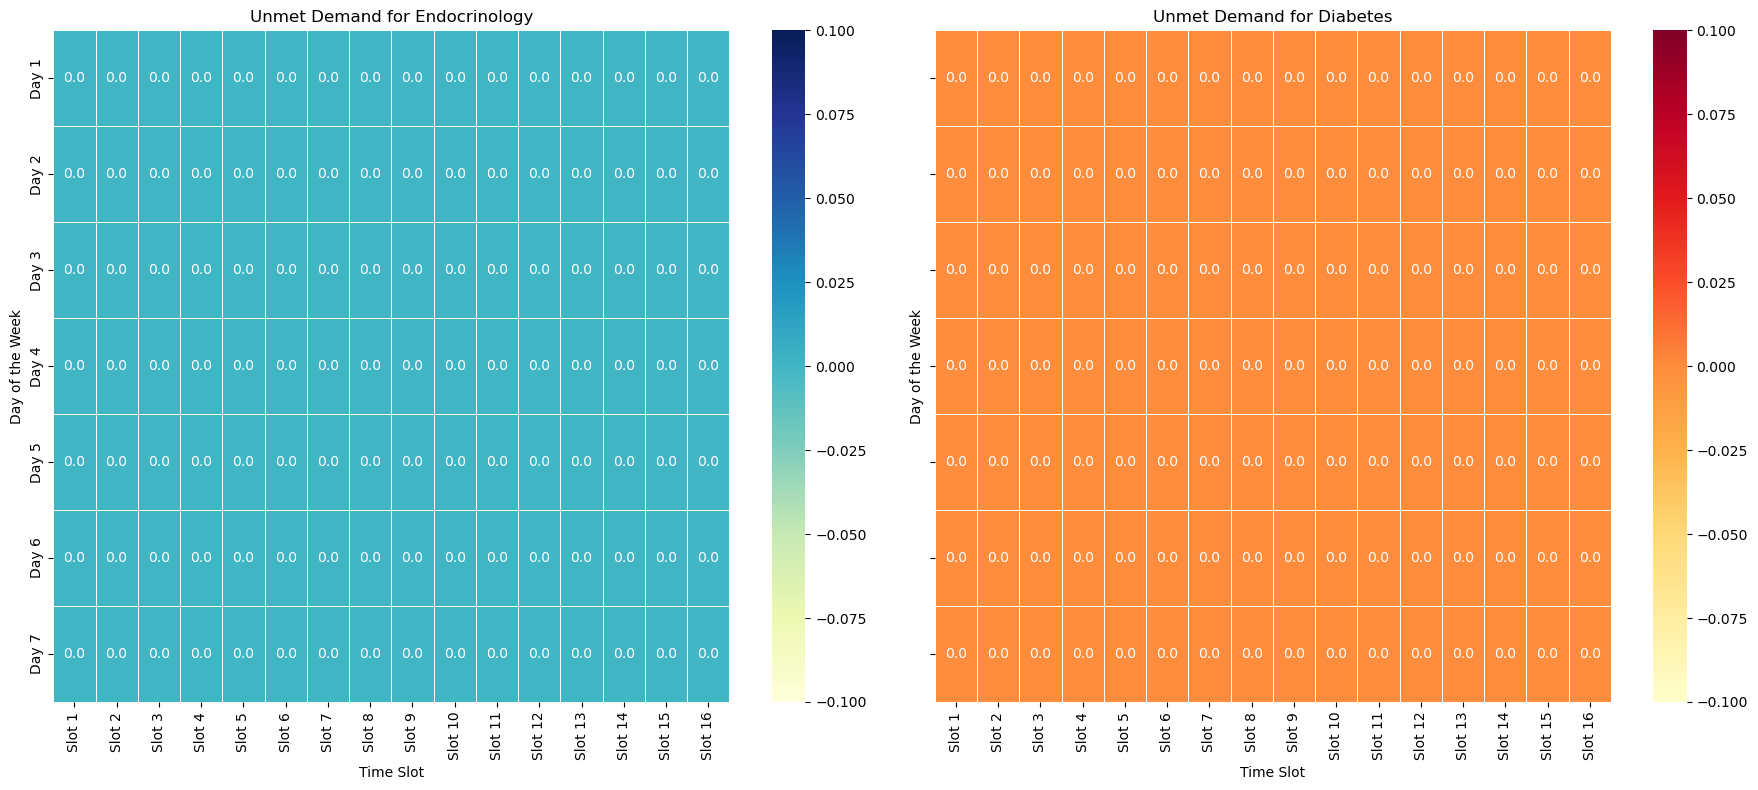

In [34]:
# Create the heatmaps
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)

# Heatmap for Endocrinology
sns.heatmap(df_unmet_endocrinology, annot=True, cmap='YlGnBu', fmt='.1f', linewidths=.5, ax=axes[0])
axes[0].set_title('Unmet Demand for Endocrinology')
axes[0].set_xlabel('Time Slot')
axes[0].set_ylabel('Day of the Week')

# Heatmap for Diabetes
sns.heatmap(df_unmet_diabetes, annot=True, cmap='YlOrRd', fmt='.1f', linewidths=.5, ax=axes[1])
axes[1].set_title('Unmet Demand for Diabetes')
axes[1].set_xlabel('Time Slot')
axes[1].set_ylabel('Day of the Week')

plt.tight_layout()
plt.show()